# Processing simulation data and comparing to theory calculations

Links to important sections:
* [Solving self-consistency equations using non-linear least squares](#lsq-rs)
* [Simulation and theory comparison plots](#sim-and-theory)


## Loading data from experiment:

The data for the experiment was generated using [this script](solve_asymmetric_CRM-multithread.jl) (simulation-scripts/experiment8/solve_asymmetric_CRM-multithread.jl).

The parameters are:
$$
M = 200\\
S = 200\\
\mu_c = M\\
\mu_e = M\\
\sigma_c = 0.2\sqrt(M)\\
\sigma_e = 0.2\sqrt(M)\\
K = 1\\
\sigma_K = 0.1\\
m = 1\\
\sigma_m = 0.
$$

In [15]:
using JLD2

In [16]:
# define sampled ρ points and number of threads
ρsdat = 0.0:0.025:1.0;
threadids = 1:16;

In [17]:
# load simulation data from multiple files into one variable

# @time sim_results = [
#     vcat((jldopen("./results/results_experiment7/experiment7-solution_ending_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];
# @time sim_results = [
#     vcat((jldopen("./results/results_experiment8/experiment8-solution_ending_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];

In [18]:
# load simulation derivative data from multiple files into one variable

# @time deriv_sim_results = [
#     vcat((jldopen("./results/results_experiment7/experiment7-solution_ending_derivatives_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];
# @time deriv_sim_results = [
#     vcat((jldopen("./results/results_experiment8/experiment8-solution_ending_derivatives_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];

In [19]:
# jldsave("./results/results_experiment7/experiment7-results.jld2";sim_results);
# jldsave("./results/results_experiment7/experiment7-deriv-results.jld2";deriv_sim_results);

In [20]:
# load data that has already been pre-processed

sim_results = jldopen("./experiment8-results.jld2")["sim_results"];
deriv_sim_results = jldopen("./experiment8-deriv-results.jld2")["deriv_sim_results"];

In [21]:
using Plots, PlotThemes, LaTeXStrings, Statistics, Random; theme(:dao)

To understand for which values of $\rho$ typical solutions are stable, we analyze the absolute values of the derivatives at the end of the simulation.

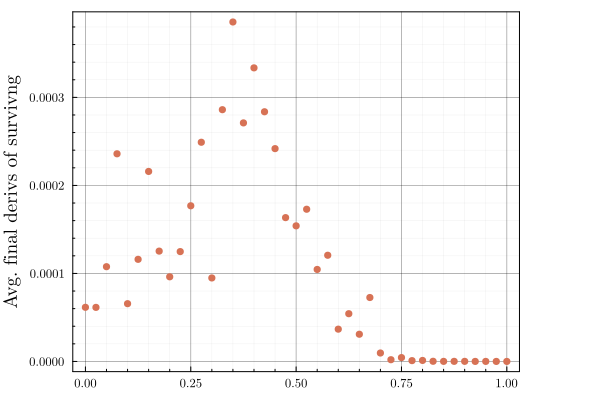

In [22]:
scatter(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)],ylabel="Avg. final derivs of survivng",label=:none)

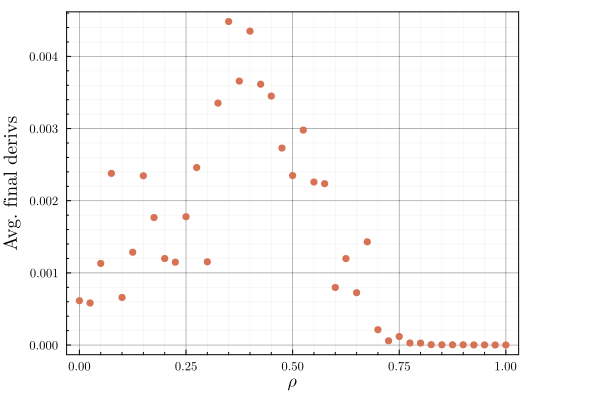

In [23]:
scatter(ρsdat,(Y->mean((X->sum(abs.(X))).(Y))).(deriv_sim_results),label=:none,xlabel=L"\rho",ylabel="Avg. final derivs")

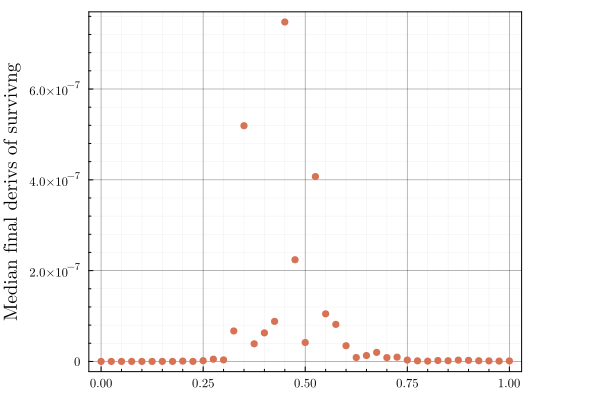

In [24]:
scatter(ρsdat,[median([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)],ylabel="Median final derivs of survivng",label=:none)


## Solving the self-consistency equations obtained from the replica-symmetric solution <a class="anchor" id="lsq-rs"></a>

In [this note](../../RSB/rsb.pdf) (RSB/rsb.pdf), we derive the self consistency equations for the variables $\phi_N,\phi_R,\langle N\rangle, \langle R\rangle, \langle N^2 \rangle, \langle R^2 \rangle$:
$$
\phi_N = \Phi(\Delta_g)\\
\phi_R = \Phi(\Delta_\kappa)\\
\nu = -\frac{\phi_N}{\sigma_c \sigma_e \rho \chi}\\
\chi = \frac{\phi_R}{1-\rho\sigma_e\sigma_c\gamma^{-1}\nu}\\
\langle N \rangle
=
\frac{\sigma_g}{\sigma_c\sigma_e\rho\chi}
\left(
    \frac{e^{-\Delta_g^2/2}}{\sqrt{2\pi}} + \Delta_g \Phi(\Delta_g)
\right)
\\
\langle R\rangle 
=
\frac{\sigma_\kappa}{1-\rho \sigma_e \sigma_c \gamma^{-1}\nu}
	\left(
		\frac{e^{-\Delta_\kappa^2/2}}{\sqrt{2\pi}}
		+
		\Delta_\kappa \Phi(\Delta_\kappa)
	\right)
\\
\langle N^2 \rangle =
	\left(
		\frac{\sigma_g}{\sigma_c\sigma_e\rho\chi}
	\right)^2
	\left(
		\frac{\Delta_g e^{-\Delta_g^2/2}}{\sqrt{2\pi}}
		+
		(1+\Delta_g^2)
		\Phi(\Delta_g)
	\right)
\\
\langle R^2 \rangle
=
	\left(
		\frac{\sigma_\kappa}{1-\rho \sigma_e \sigma_c \gamma^{-1}\nu}
	\right)^2
	\left(
		\frac{\Delta_\kappa e^{-\Delta_\kappa^2/2}}{\sqrt{2\pi}}
		+
		(1+\Delta_\kappa^2)\Phi(\Delta_\kappa)
	\right)
$$
where we have defined intermediate constants in terms of the model parameters:
$$
\gamma = M/S
	\\
		g 
	\equiv
	\mu_c \langle R\rangle
	-
	m
	\\
	\kappa
	\equiv
	K 
	-
	\mu_e \gamma^{-1} \langle N\rangle
	\\
		\sigma_g
		\equiv
		\sqrt{\sigma_m^2 + \sigma_c^2 \langle R^2 \rangle}
	\\
		\sigma_\kappa \equiv
		\sqrt{\sigma_K^2 + \gamma^{-1}\sigma_e^2 \langle N^2 \rangle}
	\\
		\Delta_\kappa \equiv \kappa/\sigma_\kappa
	\\
		\Delta_N \equiv g/\sigma_g
$$

We additionally derived the equation for replica-symmetry breaking (RSB):
$$
\rho^\star = \sqrt{\gamma^{-1} \frac{\phi_N^\star}{\phi_R^\star}}
$$

We can solve this system of equations using non-linear least squares:

In [126]:
# define all relevant quantities:

using SpecialFunctions

Φ(x) = erfc(-x/sqrt(2))/2;
w1(x) = exp(-x^2/2)/sqrt(2π) + x*Φ(x);
w2(x) = x*exp(-x^2/2)/sqrt(2π) + (1+x^2)*Φ(x);

g(eR,μc,m) = μc*eR - m;
κ(eN,μe,K,γ) = K - μe*eN/γ;
σg(qR,σc,σm) = sqrt(σm^2 + σc^2*qR);
σκ(qN,σe,σK,γ) = sqrt(σK^2 + σe^2*qN/γ);
Δκ(eN,qN,μe,σe,K,σK,γ) = κ(eN,μe,K,γ)/σκ(qN,σe,σK,γ);
Δg(eR,qR,μc,σc,m,σm) = g(eR,μc,m)/σg(qR,σc,σm);

ϕNeq(ϕN,eR,qR,μc,σc,m,σm) = ϕN - (Φ(Δg(eR,qR,μc,σc,m,σm)));
ϕReq(ϕR,eN,qN,μe,σe,K,σK,γ) = ϕR - (Φ(Δκ(eN,qN,μe,σe,K,σK,γ)));
νeq(ϕN,ν,χ,σc,σe,K,σK,m,σm,ρ) = ν - (
    -ϕN/(σc*σe*ρ*χ)
);
χeq(ϕR,ν,χ,σc,σe,γ,ρ) = χ - (
    ϕR/(1-ρ*σe*σc*ν/γ)
);
eNeq(χ,eN,eR,qR,μc,σc,σe,m,σm,ρ) = eN - (
    (σg(qR,σc,σm)/(σc*σe*ρ*χ))*w1(Δg(eR,qR,μc,σc,m,σm))
);
eReq(ν,eN,eR,qN,σc,μe,σe,K,σK,γ,ρ) = eR - (
    (σκ(qN,σe,σK,γ)/(1-ρ*σe*σc*ν/γ))*w1(Δκ(eN,qN,μe,σe,K,σK,γ))
);
qNeq(χ,eR,qN,qR,μc,σc,σe,m,σm,ρ) = qN - (
    (σg(qR,σc,σm)/(σc*σe*ρ*χ))^2*w2(Δg(eR,qR,μc,σc,m,σm))
);
qReq(ν,eN,qN,qR,σc,μe,σe,K,σK,γ,ρ) = qR - (
    (σκ(qN,σe,σK,γ)/(1-ρ*σe*σc*ν/γ))^2*w2(Δκ(eN,qN,μe,σe,K,σK,γ))
);

ρstareq(ϕN,ϕR,γ,ρ) = ρ^2 - (ϕN/ϕR)/γ; # replica symmetry breaking point

# least squares solution:

lsqobj(μc,σc,μe,σe,K,σK,m,σm,γ,ρ) = (ϕN,ϕR,ν,χ,eN,eR,qN,qR) -> (
    ϕNeq(ϕN,eR,qR,μc,σc,m,σm)^2
    +
    ϕReq(ϕR,eN,qN,μe,σe,K,σK,γ)^2
    +
    νeq(ϕN,ν,χ,σc,σe,K,σK,m,σm,ρ)^2
    +
    χeq(ϕR,ν,χ,σc,σe,γ,ρ)^2
    +
    eNeq(χ,eN,eR,qR,μc,σc,σe,m,σm,ρ)^2
    +
    eReq(ν,eN,eR,qN,σc,μe,σe,K,σK,γ,ρ)^2
    +
    qNeq(χ,eR,qN,qR,μc,σc,σe,m,σm,ρ)^2
    +
    qReq(ν,eN,qN,qR,σc,μe,σe,K,σK,γ,ρ)^2
);

lsqobjcrit(μc,σc,μe,σe,K,σK,m,σm,γ) = (ϕN,ϕR,ν,χ,eN,eR,qN,qR,ρ) -> (
    ϕNeq(ϕN,eR,qR,μc,σc,m,σm)^2
    +
    ϕReq(ϕR,eN,qN,μe,σe,K,σK,γ)^2
    +
    νeq(ϕN,ν,χ,σc,σe,K,σK,m,σm,ρ)^2
    +
    χeq(ϕR,ν,χ,σc,σe,γ,ρ)^2
    +
    eNeq(χ,eN,eR,qR,μc,σc,σe,m,σm,ρ)^2
    +
    eReq(ν,eN,eR,qN,σc,μe,σe,K,σK,γ,ρ)^2
    +
    qNeq(χ,eR,qN,qR,μc,σc,σe,m,σm,ρ)^2
    +
    qReq(ν,eN,qN,qR,σc,μe,σe,K,σK,γ,ρ)^2
    +
    ρstareq(ϕN,ϕR,γ,ρ)^2
);

In [27]:
using Optimization, OptimizationBBO

In [28]:
# the parameters the simulations were performed with:
M = 200; S = 200;
varps(ρ) = [1e0M, 2e-1sqrt(M), 1e0M, 2e-1sqrt(M), 1e0, 1e-1, 1e0, 1e-1, M/S, ρ];

In [29]:
function solve_consist(ps,ρ)
    optf = OptimizationFunction((x,p)->lsqobj(p...)(x...));
    u0 = 0.1rand(8);
    # (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
    prob = OptimizationProblem(optf,u0,ps(ρ),lb=vcat(zeros(2),-1e1ones(2),zeros(2),zeros(2)),ub=vcat(ones(2),1e1ones(2),1e1ones(2),1e1ones(2)));
    sol = solve(prob,BBO_adaptive_de_rand_1_bin(), maxiters=1_000_000,maxtime=2)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    return sol.u
end

solve_consist (generic function with 1 method)

In [32]:
function get_ρstar()
    pcrit = varps(1.0)[1:end-1]
    optf = OptimizationFunction((x,p)->lsqobjcrit(p...)(x...));
    u0 = vcat(0.2ones(8),[0.7]);
    # (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
    critprob = OptimizationProblem(optf,u0,pcrit,lb=vcat(zeros(2),-1e1ones(2),zeros(2),zeros(2),zeros(1)),ub=vcat(ones(2),1e1ones(2),1e1ones(2),1e1ones(2),ones(1)));
    # sol = solve(prob,BBO_adaptive_de_rand_1_bin_radiuslimited(), maxiters=1_000_000,maxtime=5)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    # sol = solve(prob,BBO_de_rand_2_bin(), maxiters=1_000_000,maxtime=5)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    solcrit = solve(critprob,BBO_adaptive_de_rand_1_bin(), maxiters=1_000_000,maxtime=0.5)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    ρstar_lsq = solcrit.u[end]; println("ρ⋆ LSQ = ",ρstar_lsq);
    lsqobj = lsqobjcrit(pcrit...)(solcrit.u...);
    println("LSQ obj = ",lsqobj)
    if lsqobj > 1e-9
        get_ρstar()
    else 
        return ρstar_lsq
    end
end

get_ρstar (generic function with 1 method)

The value of 

In [33]:
ρstar_lsq=get_ρstar()

ρ⋆ LSQ = 0.6380012384395968
LSQ obj = 3.845277120409867e-34


0.6380012384395968

The following cell solves the self-consistency equation for various finely-spaced values of $\rho$. It may take a while, so instead run the cell below to load in results.

In [37]:

ρscalc = 0.0025:0.0025:1.0
dat = (ρ -> solve_consist(varps,ρ)).(ρscalc);

In [38]:
# jldsave("lsq_res.jld2";dat);
ρscalc = 0.0025:0.0025:1.0
dat=jldopen("lsq_res.jld2")["dat"];

In [40]:
# the objective functions of the least squares solutions:
lsqsolobjs = [lsqobj(varps(ρscalc[i])...)(dat[i]...) for i in eachindex(ρscalc)]

400-element Vector{Float64}:
 3.318240793797042e-5
 3.2907379673350934e-5
 3.261435996278507e-5
 3.227611823991082e-5
 3.18859749276132e-5
 3.1443243762637764e-5
 3.0950055004966965e-5
 3.0410290926692e-5
 2.9829060657387565e-5
 2.9212315485602463e-5
 2.8566498278306918e-5
 2.789821401658642e-5
 2.721393749579396e-5
 ⋮
 3.7618757962190256e-35
 9.371040964755276e-35
 2.172607433907293e-35
 9.934176227196078e-35
 1.476891102373122e-34
 6.262519622402663e-35
 3.0018599236948756e-34
 4.09862554037084e-34
 5.961005321416746e-35
 4.2359673615850394e-35
 5.690862025918399e-35
 4.8224655742484345e-36

In [41]:
# the indices of valid solutions:
solinds = lsqsolobjs .< 1e-20;

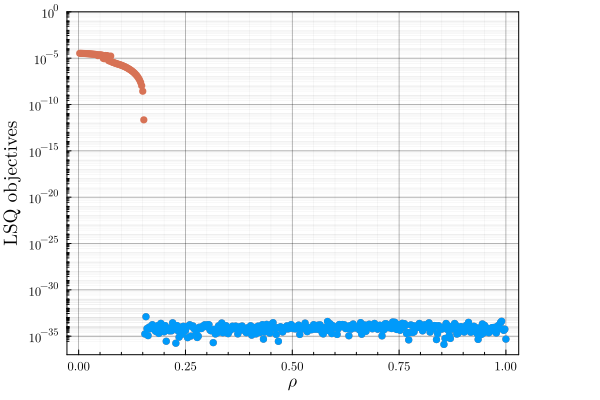

In [48]:
scatter(ρscalc,lsqsolobjs,yscale=:log10,ylim=(1e-37,1e0),yticks=10. .^ (-35:5:0),label=:none)
scatter!(ρscalc[solinds],lsqsolobjs[solinds],yscale=:log10,ylim=(1e-37,1e0),label=:none)
plot!(xlabel=L"\rho",ylabel="LSQ objectives")

### Some technical details for numerics:

(it might be worth skipping this section)

In [49]:
struct SimRes #data structure for simulation results
    ϕN::Float64
    ϕR::Float64
    eN::Float64
    eR::Float64
    qN::Float64
    qR::Float64
    SimRes(sim_data::Vector{Vector{Float64}},S::Int64,M::Int64,ϕNtol::Float64,ϕRtol::Float64) = new(
        (Y->mean((X->mean(X[1:S] .> ϕNtol)).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end] .> ϕRtol)).(Y)))(sim_data),
        (Y->mean((X->mean(X[1:S])).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end])).(Y)))(sim_data),
        (Y->mean((X->mean(X[1:S].^2)).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end].^2)).(Y)))(sim_data)
    )
end

struct RS #data structure for replica-symmetry theory results
    ϕN::Float64
    ϕR::Float64
    ν::Float64
    χ::Float64
    eN::Float64
    eR::Float64
    qN::Float64
    qR::Float64
    RS(lsq_data) = new(lsq_data...)
end

In [50]:
# load in simulation data and theory solutions
sr=(X->SimRes(X,S,M,10^(-2.2),10^(-2.8))).(sim_results);
rs = (X->RS(X)).(dat);

Here, we plot the relationship $\rho -\sqrt{\gamma^{-1}\phi_N/\phi_R}$ from both theory and simulations to show the value of $\rho^\star$:

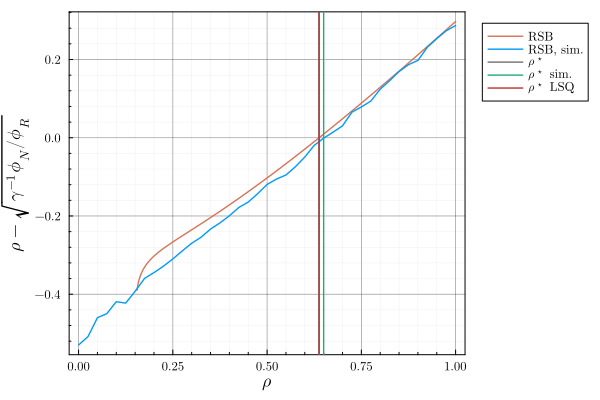

In [51]:
# σc = 2e-1sqrt(M);
# σe = 2e-1sqrt(M);
γ = M/S;
ρstar =ρscalc[findmin([((X,ρ) -> abs(ρ - sqrt(X.ϕN/(X.ϕR*γ))))(rs[i],ρscalc[i]) for i in eachindex(rs)])[end]]
ρstar_sr =ρsdat[findmin([((X,ρ) -> abs(ρ - sqrt(X.ϕN/(X.ϕR*γ))))(sr[i],ρsdat[i]) for i in eachindex(sr)])[end]]
# let tol = 1e-10
    plot(ρscalc[solinds],[((X,ρ) -> (ρ - sqrt(X.ϕN/(X.ϕR*γ))))(rs[i],ρscalc[i]) for i in eachindex(rs)][solinds],label="RSB")
    plot!(ρsdat[:],[((X,ρ) -> (ρ - sqrt(X.ϕN/(X.ϕR*γ))))(sr[i],ρsdat[i]) for i in eachindex(sr)][:],label="RSB, sim.")
    # plot!(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> (ρ^2*X.ϕR - X.ϕN/γ))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot!(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> ρ^2*X.χ^2*(1-X.ν*ρ*σc*σe/γ)^2 -X.ϕN*X.ϕR/γ)(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕR*((1+2ρ^2)*X.ϕN/γ-X.ϕR*(ρ^2 * X.ϕR)))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    plot!(ylabel=L"\rho - \sqrt{\gamma^{-1}\phi_N/\phi_R}",xlabel=L"\rho")
    vline!([ρstar],label=L"\rho^\star",xlim=(-0.025,1.025))
    vline!([ρstar_sr],label=L"$\rho^\star$ sim.",xlim=(-0.025,1.025))
    vline!([ρstar_lsq],label=L"$\rho^\star$ LSQ",xlim=(-0.025,1.025))
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> ρ - (γ*X.ϕR/X.ϕN - 2)^(-1/2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot!(ylabel=L"\rho^2 \phi_R - (1 + 2 \rho^2)\gamma^{-1}\phi_N",xlabel=L"\rho")
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕN*X.ϕR/γ - ρ^2 * X.χ^2*(1-(X.ϕN/(X.χ*γ))^2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol])
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕN*X.ϕR-ρ^2 * X.χ^2*(1-(X.ν*ρ*σc*σe/γ)^2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol])
# end

In [52]:
cat_all_N_results = vcat([vcat((Y -> Y[1:S]).(X)...) for X in sim_results]...);
cat_all_R_results = vcat([vcat((Y -> Y[(end-M+1):end]).(X)...) for X in sim_results]...);
cat_all_results = vcat([vcat((Y -> Y[:]).(X)...) for X in sim_results]...);

When determining $\phi_R$ and $\phi_N$ from the simulations we need to choose a tolerance below which we consider species populations/resource abundances to be zero; this is due to numerical error.
A empirical CDF/histogram plot of the values of species populations and abundances at the end of the simulation can help us choose the appropriate tolerance:

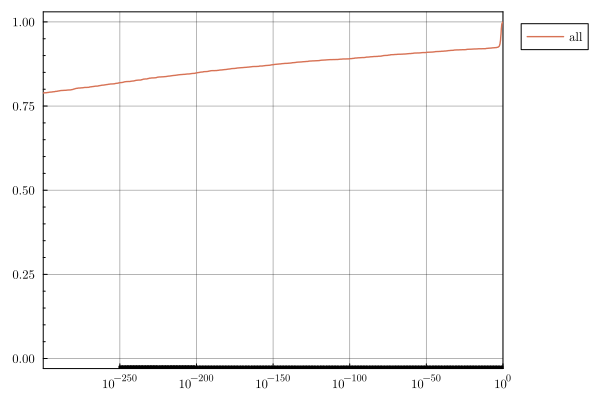

In [55]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(0),cat_all_results))[1:5000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
    xlim=(1e-300,:auto),
    label = "all",
#     yscale=:log10,
    xticks=10. .^ (-300:50:0),
    minorgrid=:none
)

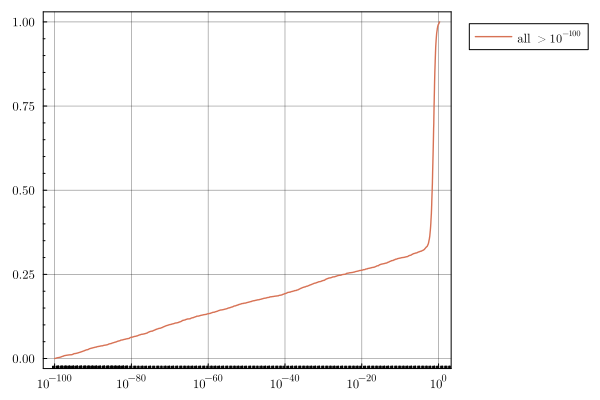

In [57]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-100),cat_all_results))[1:4000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
    label = L"all $>10^{-100}$",
#     yscale=:log10,
    xticks=10. .^ (-100:20:0),
    minorgrid=:none
)

We will choose separate tolerances for species and resources:

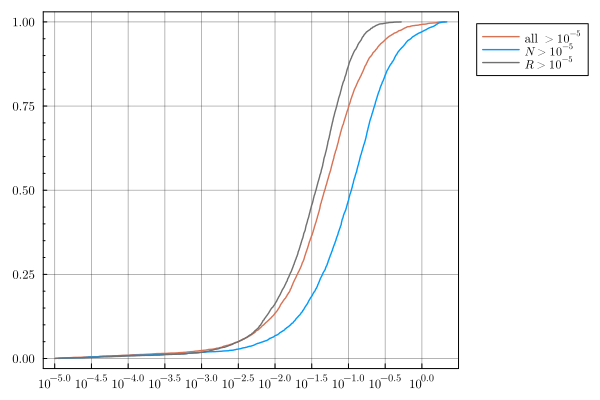

In [64]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_results))[1:5000]);
cat_all_N_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_N_results))[1:5000]);
cat_all_R_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_R_results))[1:5000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
    label = L"all $>10^{-5}$",
#     yscale=:log10,
    xticks=10. .^ (-10:0.5:0),
    minorgrid=:none
)
plot!(cat_all_N_results_trunc_sort,(1:size(cat_all_N_results_trunc_sort,1))./size(cat_all_N_results_trunc_sort,1),label = L"N>10^{-5}")
plot!(cat_all_R_results_trunc_sort,(1:size(cat_all_R_results_trunc_sort,1))./size(cat_all_R_results_trunc_sort,1),label = L"R>10^{-5}")

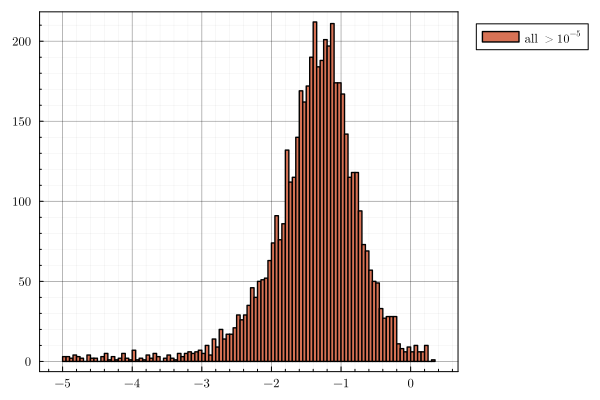

In [66]:
# cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-6),cat_all_results))[1:5000]);
histogram(log10.(cat_all_results_trunc_sort),bins=200,label=L"all $> 10^{-5}$")
# note!!! the axis is logarithmic!

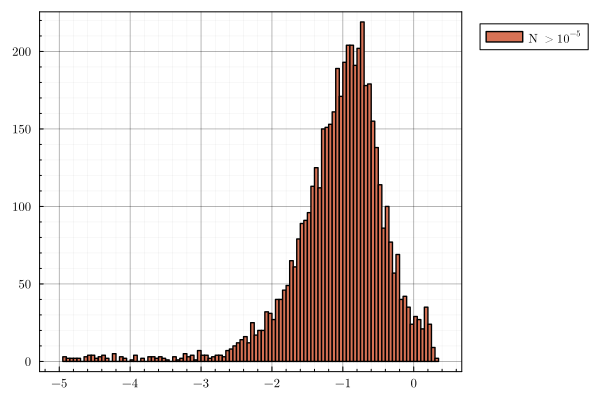

In [67]:
histogram(log10.(cat_all_N_results_trunc_sort),bins=200,label=L"N $> 10^{-5}$")
# note!!! the axis is logarithmic!

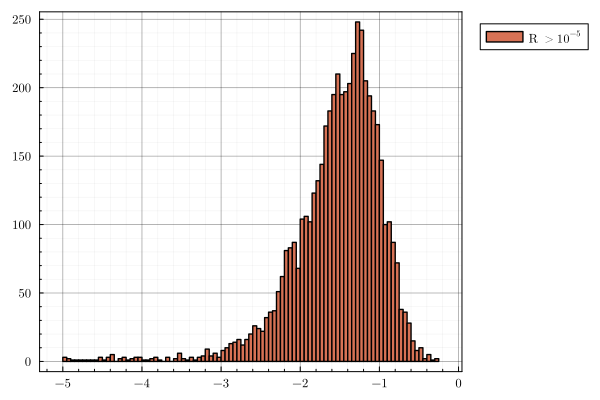

In [68]:
histogram(log10.(cat_all_R_results_trunc_sort),bins=200,label=L"R $> 10^{-5}$")

## Comparing simulation and theory:  <a class="anchor" id="sim-and-theory"></a>

Now, we plot simulation and replica-symmetric theory results simultaneously:

Find the value of $\rho$ where the simulation and least squares solutions overlap:

In [70]:
# matchingsol_ρs = vcat(((X -> ρscalc[solinds][X .∈ ρscalc[solinds]]).(ρsdat))...);
# matching_indices=sum(((X->(X .∈ ρscalc[solinds])).(matchingsol_ρs))) .> 0;
matching_calc_indices=BitVector(sum((X -> X .∈ ρscalc[solinds]).(ρsdat)));
matching_dat_indices=BitVector(sum((X -> X .∈ ρsdat).(ρscalc[solinds])));

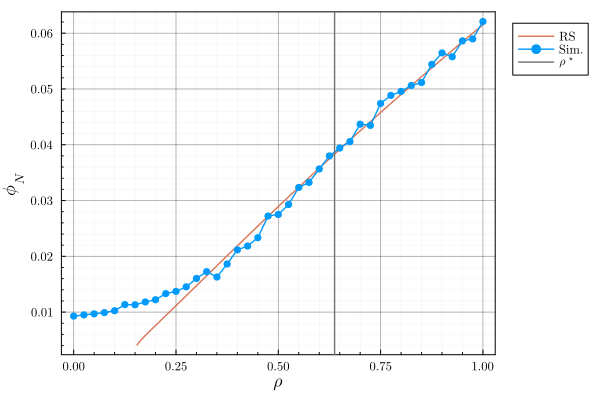

In [71]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕN).(rs)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


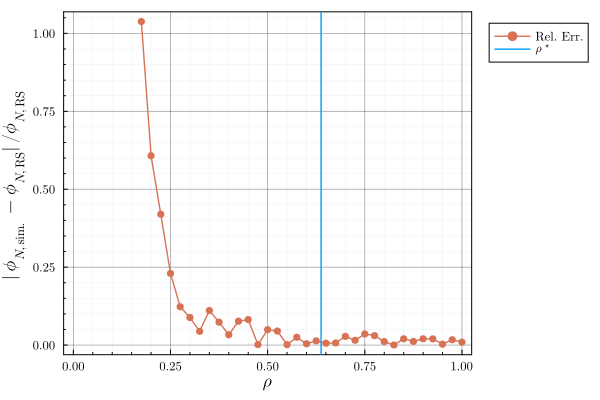

In [76]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.ϕN).(sr)[matching_dat_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",xlabel=L"\rho",ylabel=L"|\phi_{N,\mathrm{sim.}}-\phi_{N,\mathrm{RS}}|/\phi_{N,\mathrm{RS}}")


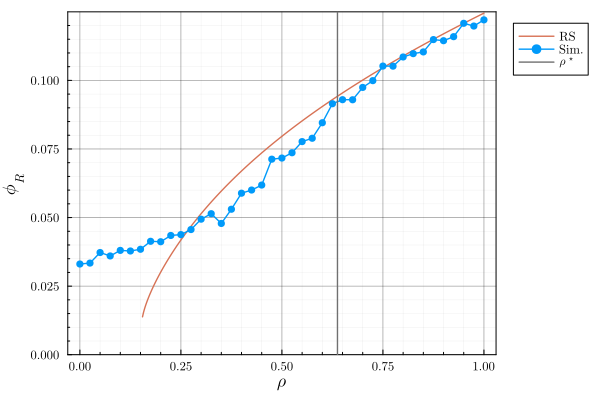

In [89]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕR).(rs)[solinds],ylim=(0,0.125),label="RS",ylabel=L"\phi_R",xlabel=L"\rho")
plot!(ρsdat,(X->X.ϕR).(sr),label="Sim.",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end] .> 10^(-2.8))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


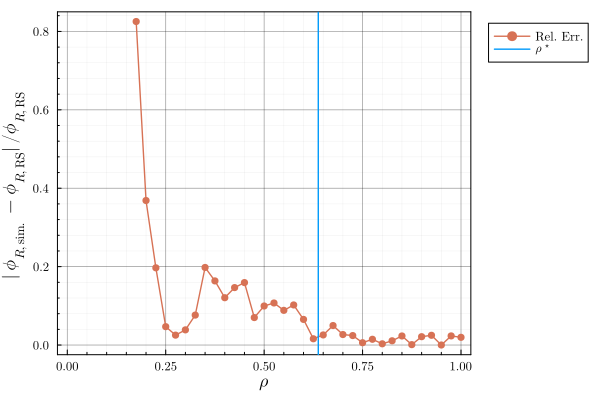

In [78]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.ϕR).(sr)[matching_dat_indices],(X->X.ϕR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",xlabel=L"\rho",ylabel=Lylabel=L"|\phi_{R,\mathrm{sim.}}-\phi_{R,\mathrm{RS}}|/\phi_{R,\mathrm{RS}}")


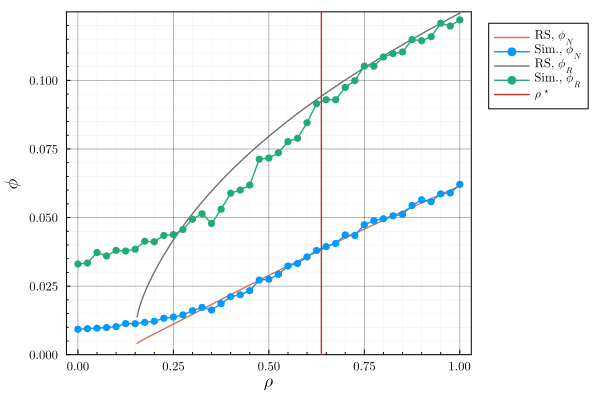

In [91]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕN).(rs)[solinds],ylabel=L"\phi",xlabel=L"\rho",label=L"RS, $\phi_N$")
plot!(ρsdat,(X->X.ϕN).(sr),label=L"Sim., $\phi_N$",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot!(ρscalc[solinds],(X->X.ϕR).(rs)[solinds],ylim=(0,0.125),label=L"RS, $\phi_R$",xlabel=L"\rho")
plot!(ρsdat,(X->X.ϕR).(sr),label=L"Sim., $\phi_R$",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end] .> 10^(-2.8))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


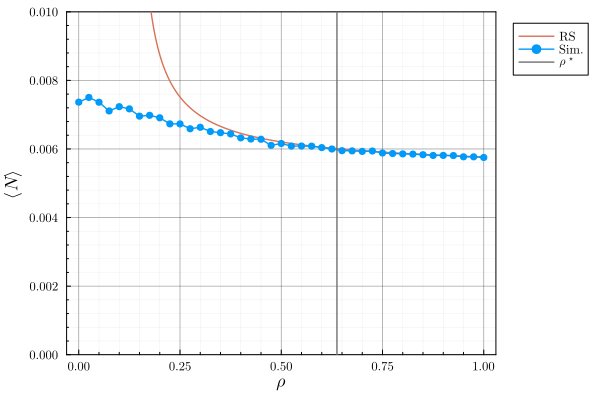

In [92]:
plot(ρscalc[solinds],(X->X.eN).(rs)[solinds],ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# plot(ρscalc,(X->X[5]).(dat),ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S])).(Y))).(sim_results),label="Sim.")
plot!(ρsdat,(X->X.eN).(sr),label="Sim.",marker=:circle)
vline!([ρstar],label=L"\rho^\star")


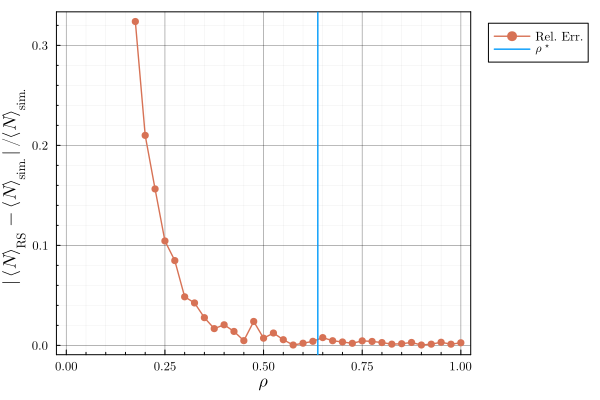

In [84]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.eN).(sr)[matching_dat_indices],(X->X.eN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",xlabel=L"\rho",ylabel=L"|\langle N \rangle_\mathrm{RS} - \langle N \rangle_\mathrm{sim.}|/\langle N \rangle_\mathrm{sim.}")


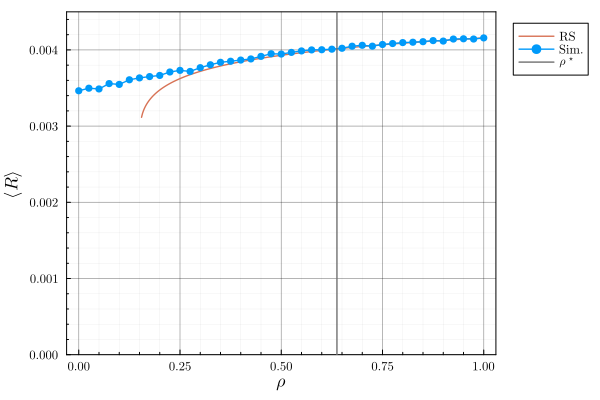

In [81]:
plot(ρscalc[solinds],(X->X.eR).(rs)[solinds],ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.eR).(sr),label="Sim.",ylim=(0,0.0045),marker=:circle)
# plot(ρscalc,(X->X[6]).(dat),ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end])).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",ylabel=L"\langle R \rangle")




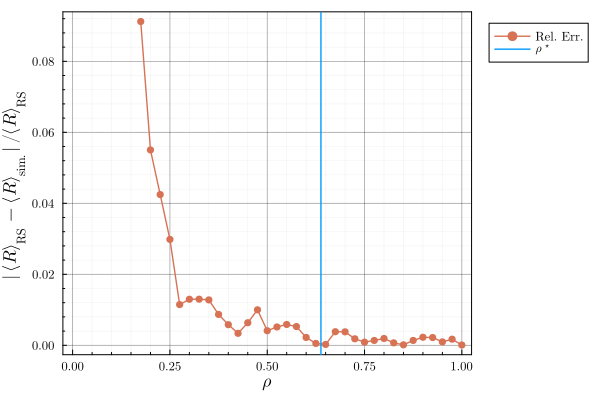

In [86]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.eR).(sr)[matching_dat_indices],(X->X.eR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar_lsq],label=L"\rho^\star",xlabel=L"\rho",ylabel=L"|\langle R \rangle_\mathrm{RS} - \langle R \rangle_\mathrm{sim.}|/\langle R \rangle_\mathrm{RS}")


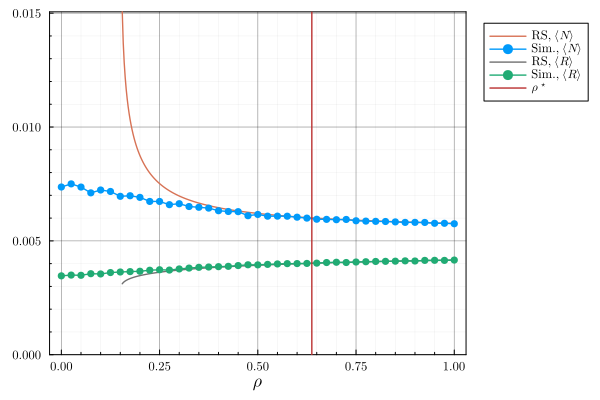

: 

In [114]:
plot(ρscalc[solinds],(X->X.eN).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle N \rangle$")
# plot(ρscalc,(X->X[5]).(dat),ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S])).(Y))).(sim_results),label="Sim.")
plot!(ρsdat,(X->X.eN).(sr),label=L"Sim., $\langle N \rangle$",marker=:circle)
plot!(ρscalc[solinds],(X->X.eR).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle R \rangle$")
plot!(ρsdat,(X->X.eR).(sr),label=L"Sim., $\langle R \rangle$",marker=:circle,
# yscale=:log10
ylim=(0,:auto)
)
# plot!(ρsdat,(X->X.eR).(sr),label=L"Sim., $\langle R \rangle$",marker=:circle,ylim=(0,0.01))
vline!([ρstar],label=L"\rho^\star")
# plot(ρscalc,(X->X[6]).(dat),ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end])).(Y))).(sim_results),label="Sim.")



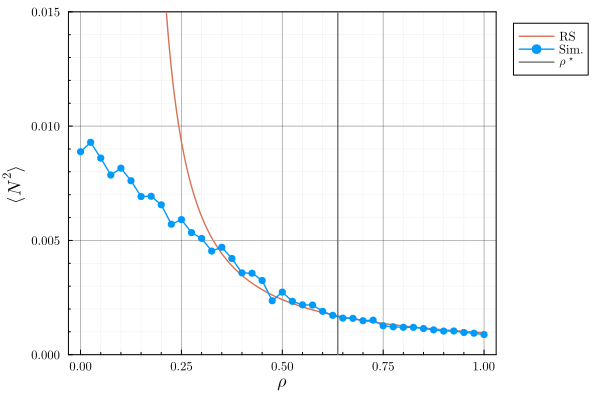

In [87]:
plot(ρscalc[solinds],(X->X.qN).(rs)[solinds],ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
# plot(ρscalc,(X->X[7]).(dat),ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
plot!(ρsdat,(X->X.qN).(sr),label="Sim.",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S].^2)).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


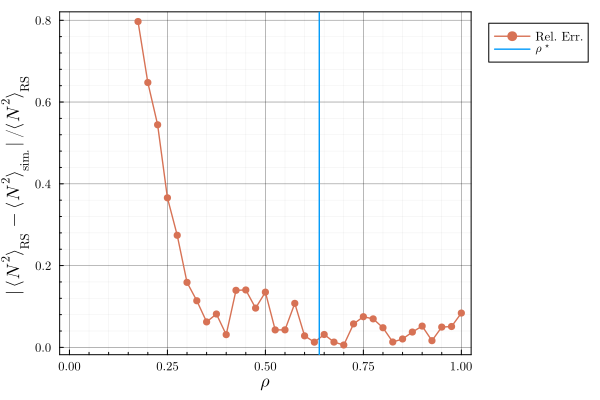

In [88]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.qN).(sr)[matching_dat_indices],(X->X.qN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",xlabel=L"\rho",ylabel=L"|\langle N^2 \rangle_\mathrm{RS} - \langle N^2 \rangle_\mathrm{sim.}|/\langle N^2 \rangle_\mathrm{RS}")


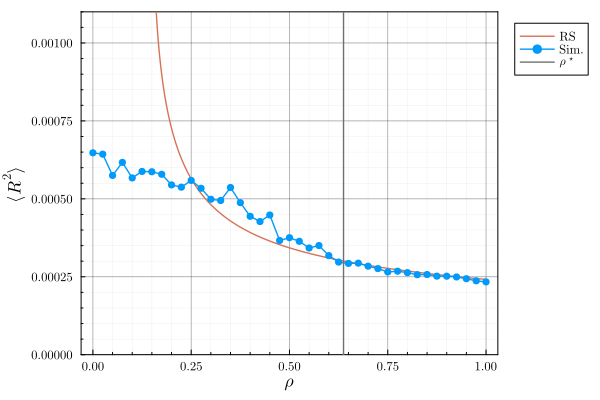

In [89]:
plot(ρscalc[solinds],(X->X.qR).(rs)[solinds],ylim=(0,0.0011),ylabel=L"\langle R^2\rangle",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.qR).(sr),label="Sim.",marker=:circle)
vline!([ρstar],label=L"\rho^\star")



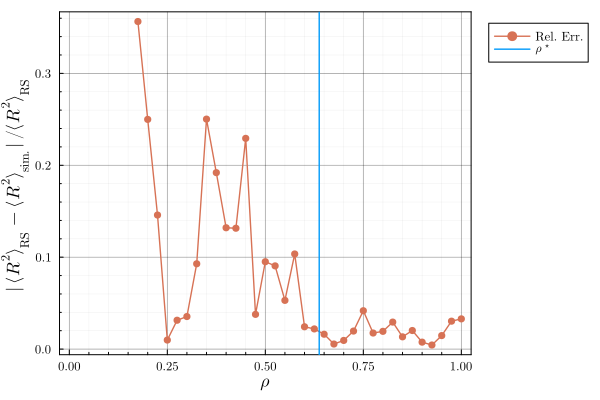

In [90]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.qR).(sr)[matching_dat_indices],(X->X.qR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),
# yscale=:log10
)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star",xlabel=L"\rho",ylabel=L"|\langle R^2 \rangle_\mathrm{RS} - \langle R^2 \rangle_\mathrm{sim.}|/\langle R^2 \rangle_\mathrm{RS}")


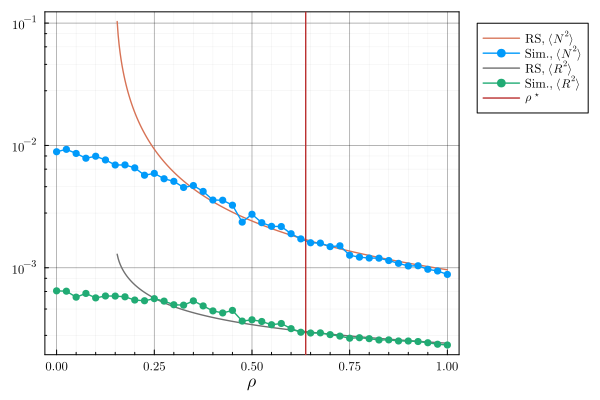

In [101]:
plot(ρscalc[solinds],(X->X.qN).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle N^2\rangle$")
# plot(ρscalc,(X->X[7]).(dat),ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
plot!(ρsdat,(X->X.qN).(sr),label=L"Sim., $\langle N^2\rangle$",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S].^2)).(Y))).(sim_results),label="Sim.")
# vline!([ρstar],label=L"\rho^\star")
plot!(ρscalc[solinds],(X->X.qR).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle R^2\rangle$")
plot!(ρsdat,(X->X.qR).(sr),label=L"Sim., $\langle R^2\rangle$",marker=:circle,yscale=:log10)#ylim=(0,0.015)
vline!([ρstar],label=L"\rho^\star")



Now, we compare $\rho^\star$ to the values of final derivatives:

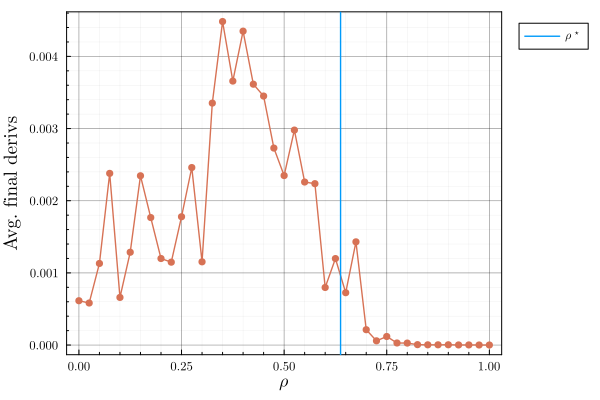

In [97]:
# scatter(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)])
plot(ρsdat,(Y->mean((X->sum(abs.(X))).(Y))).(deriv_sim_results),label=:none,xlabel=L"\rho",ylabel="Avg. final derivs",
# yscale=:log10,
marker=:circle
)

vline!([ρstar],label=L"\rho^\star")



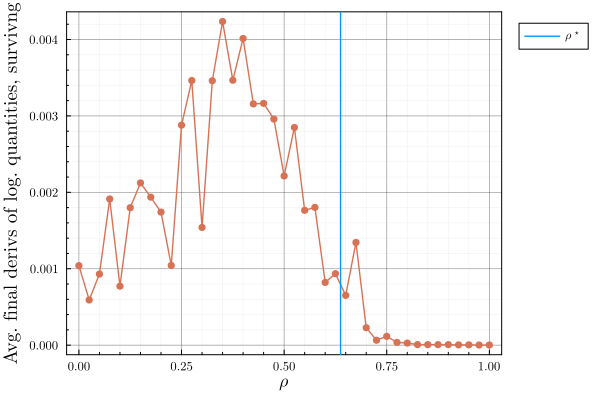

In [99]:
let tol=1e-3
    plot(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> tol]./filter(>(tol),sim_results[ρi][i]))) for i in 1:160]) for ρi in eachindex(ρsdat)],
# yscale=:log10,
marker=:circle,
ylabel="Avg. final derivs of log. quantities, survivng",
xlabel=L"\rho",
label=:none
)
end

# vline!([ρstar_sr],label=L"\rho^\star")
vline!([ρstar],label=L"\rho^\star")


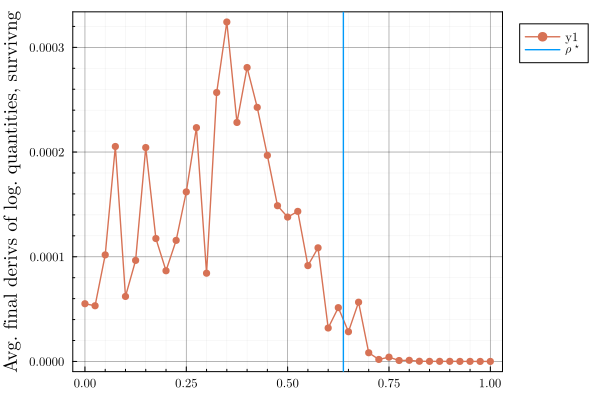

In [112]:
let tol = 1e-6
    plot(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> tol])) for i in 1:160]) for ρi in eachindex(ρsdat)],
    # yscale=:log10,
    marker=:circle,
    ylabel="Avg. final derivs of log. quantities, survivng"
    )
    vline!([ρstar],label=L"\rho^\star")
end


Now, we plot all the same stuff except at various quantiles of the distribution to get a sense of its shape and questions like, "where does this transition point really occur? are there especially unstable outliers skewing data?"

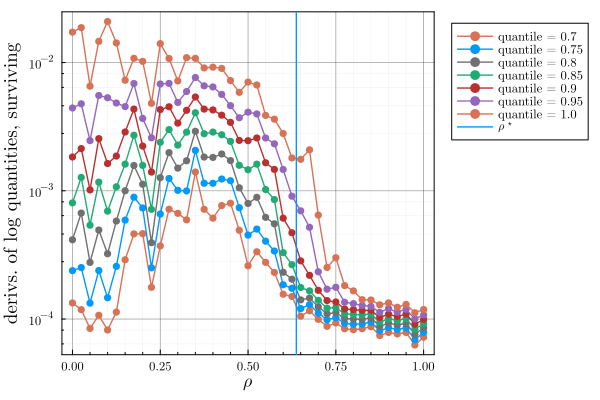

In [125]:
plot()
let tol = 1e-20
for i in 0.7:0.05:1#0:0.05:0.3
plot!(ρsdat,[(X->mean(filter(<(quantile(X,i)),X)))(
    # [mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> tol])) for i in 1:160]
    [mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 10^(-20)]./filter(>(10^(-20)),sim_results[ρi][i]))) for i in 1:160]
    ) for ρi in eachindex(ρsdat)],
yscale=:log10,
marker=:circle,
label = "quantile = "*string(i),
xlabel = L"\rho",
ylabel = "derivs. of log quantities, surviving"
)
end
end
vline!([ρstar],label=L"\rho^\star")
